### why wasserstein
- https://jamesmccaffrey.wordpress.com/2021/08/23/comparing-wasserstein-distance-with-kullback-leibler-distance/

*We haver common support of all points, so in theory KL and JS can be used.

### this impl.
- https://github.com/pkomiske/Wasserstein/
- https://github.com/pkomiske/Wasserstein/blob/master/demos/Wasserstein%20Demo.ipynb
- https://pypi.org/project/Wasserstein/
- https://pkomiske.github.io/Wasserstein/


### Potentiall More scalable version:
- https://github.com/lrcfmd/ElM2D
- https://github.com/sparks-baird/chem_wasserstein
- https://pypi.org/project/chem_wasserstein/
- https://github.com/KrishnaswamyLab/DiffusionEMD

### pytorch appprox:
- https://dfdazac.github.io/sinkhorn.html (THIS!)
- https://github.com/dfdazac/wassdistance
- https://github.com/gpeyre/SinkhornAutoDiff
- https://www.kernel-operations.io/geomloss/index.html
- https://www.kernel-operations.io/geomloss/api/pytorch-api.html (potentially interesting loss!!!)
- https://github.com/dfdazac/wassdistance/blob/master/layers.py (mini batch implimentation)

more pytorch sinkhorn:
- https://gist.github.com/wohlert/8589045ab544082560cc5f8915cc90bd
- https://gist.github.com/noskill/c32f2e6148e14f2f9a2945b03bab42ac

# TODO

- Check scalability on computerome...
- Read more..

In [99]:
import numpy as np
from scipy import stats
import torch
from layers import SinkhornDistance
import wasserstein
import matplotlib.pyplot as plt
import time
import geomloss # also needs: pip install pykeops


# 1d

In [20]:
# data
M = 25 # go higer then and lap top can't allocate enough ram. No issue on computerome
coords0, coords1 = np.random.rand(2, M,1) # would be spatial coordinates of dist0 and dist1
weights0, weights1 = np.ones([2,M]) # no/same weights

# scipy---------------------------------------------------
wass = stats.wasserstein_distance(coords0.flatten(),coords1.flatten())
print('Wasserstein distance (scipy):', wass)

#wasserstein ---------------------------------------------
emd = wasserstein.EMD(norm=True, n_iter_max = 1000)
emd_val = emd(weights0, coords0, weights1, coords1)
print('Wasserstein distance (wasserstein):', emd_val)

#sinkhorn -------------------------------------------------
x = torch.tensor(coords0, dtype=torch.float)
y = torch.tensor(coords1, dtype=torch.float)
sinkhorn = SinkhornDistance(eps=1, max_iter=1000, reduction='none')
dist, P, C = sinkhorn(x, y)
print(f"Sinkhorn distance: {dist.item()}")

# GeomLoss
loss = geomloss.SamplesLoss(loss='sinkhorn', p = 2, blur= 0.001)
sinkhornLoss = loss(x,y)
print(f"Sinkhorn distance (GeomLoss): {sinkhornLoss}")

Wasserstein distance (scipy): 0.05902008593836761
Wasserstein distance (wasserstein): 0.0590200859383676
Sinkhorn distance: 0.13773588836193085
Sinkhorn distance (GeomLoss): 0.0020285076461732388


In [56]:
iterations = 1000

w_list1= []
w_list2= []
s_list1= []
s_list2= []

for i in range(iterations):

    # data
    M = 25 # go higer then and lap top can't allocate enough ram. No issue on computerome
    coords0, coords1 = np.random.rand(2, M,1) # would be spatial coordinates of dist0 and dist1
    weights0, weights1 = np.ones([2,M]) # no/same weights

    # scipy---------------------------------------------------
    wass = stats.wasserstein_distance(coords0.flatten(),coords1.flatten())
    #print('Wasserstein distance (scipy):', wass)
    w_list1.append(wass)

    #wasserstein ---------------------------------------------
    emd = wasserstein.EMD(norm=True, n_iter_max = 1000)
    emd_val = emd(weights0, coords0, weights1, coords1)
    #print('Wasserstein distance (wasserstein):', emd_val)
    w_list2.append(emd_val)

    #sinkhorn -------------------------------------------------
    x = torch.tensor(coords0, dtype=torch.float)/M
    y = torch.tensor(coords1, dtype=torch.float)/M
    sinkhorn = SinkhornDistance(eps=1, max_iter=1000, reduction='none')
    dist, P, C = sinkhorn(x, y)
    #print(f"Sinkhorn distance: {dist.item()}")
    s_list1.append(dist)

    # GeomLoss
    loss = geomloss.SamplesLoss(loss='sinkhorn', p = 1, blur= 0.001)
    #loss = geomloss.SamplesLoss(loss='sinkhorn', p = 2, blur= 0.05, scaling=0.8)
    sinkhornLoss = loss(x,y)
    #print(f"Sinkhorn distance (GeomLoss): {sinkhornLoss}")
    s_list2.append(sinkhornLoss)

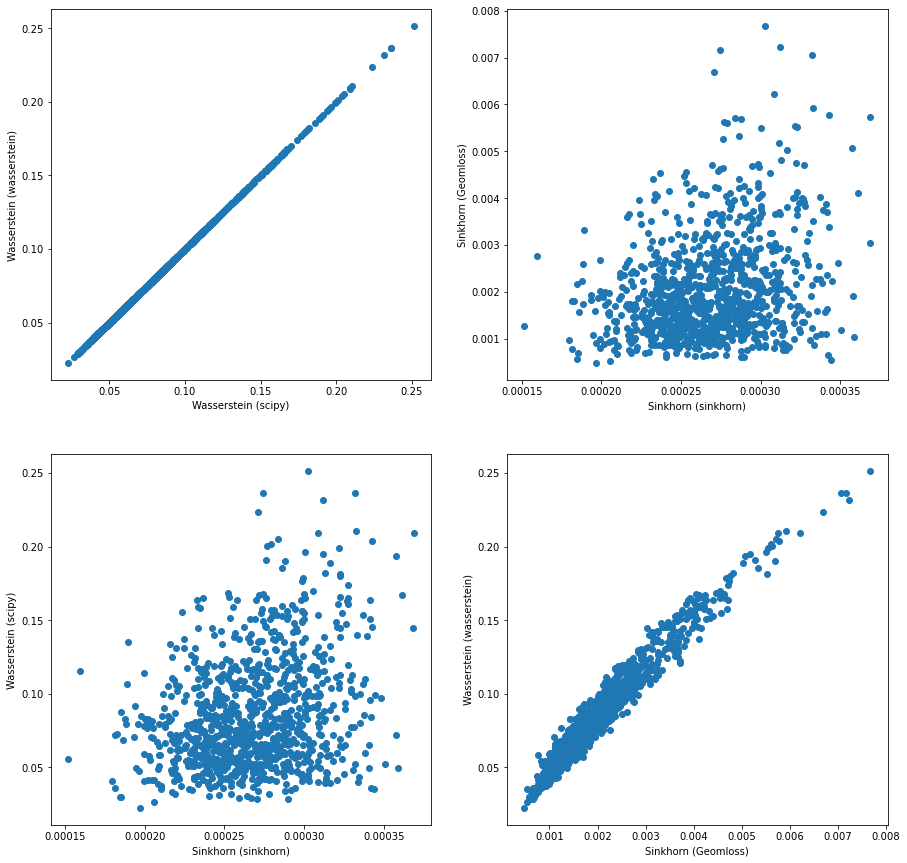

In [57]:

plt.figure(figsize=[15,15])

plt.subplot(2,2,1)
plt.plot(w_list1, w_list2, 'o')
plt.xlabel('Wasserstein (scipy)')
plt.ylabel('Wasserstein (wasserstein)')

plt.subplot(2,2,2)
plt.plot(s_list1, s_list2, 'o')
plt.xlabel('Sinkhorn (sinkhorn)')
plt.ylabel('Sinkhorn (Geomloss)')

plt.subplot(2,2,3)
plt.plot(s_list1, w_list1, 'o')
plt.xlabel('Sinkhorn (sinkhorn)')
plt.ylabel('Wasserstein (scipy)')

plt.subplot(2,2,4)
plt.plot(s_list2, w_list2, 'o')
plt.xlabel('Sinkhorn (Geomloss)')
plt.ylabel('Wasserstein (wasserstein)')

plt.show()

# 2d

In [5]:
def show_wasserstein2d(emdm, weights0, coords0, weights1, coords1):

    flows = emd.flows()

    # plot the events
    plt.scatter(coords0[:,0], coords0[:,1], lw=0, color='red')
    plt.scatter(coords1[:,0], coords1[:,1], lw=0, color='blue')

    # plot flows
    cmap = plt.get_cmap('Greys')
    fmax = flows.max()
    for i in range(len(weights0)):
        for j in range(len(weights1)):
            f = flows[i,j]
            if f > 0.:
                plt.plot([coords0[i,0], coords1[j,0]], [coords0[i,1], coords1[j,1]],
                        lw=1.5, color=cmap(f/fmax), zorder=0)

    plt.axis('off')
    plt.show()


def show_sinkhorn2d(a, b, P):    
    norm_P = P/P.max()
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            plt.arrow(a[i, 0], a[i, 1], b[j, 0]-a[i, 0], b[j, 1]-a[i, 1],
                     alpha=norm_P[i,j].item())
    plt.scatter(a[:, 0], a[:, 1], color='red')
    plt.scatter(b[:, 0], b[:, 1], color='blue')
    plt.axis('off')

In [58]:
# data
M = 25 # go higer then and lap top can't allocate enough ram. No issue on computerome
coords0, coords1 = np.random.rand(2, M, 2) # would be spatial coordinates of dist0 and dist1
weights0, weights1 = np.ones([2,M]) # no/same weights

# scipy -----------------------------------------
# can do weights but not 2d...
# wass = stats.wasserstein_distance(coords0, coords1, weights0, weights0)
# print('Wasserstein distance (scipy):', wass)


#wasserstein ---------------------------------------------
emd = wasserstein.EMD(norm=True, n_iter_max = 1000)
emd_val = emd(weights0, coords0, weights1, coords1)
print('Wasserstein distance:', emd_val)


#sinkhorn -------------------------------------------------
x = torch.tensor(coords0, dtype=torch.float)
y = torch.tensor(coords1, dtype=torch.float)

sinkhorn = SinkhornDistance(eps=0.0001, max_iter=1000, reduction='none')
dist, P, C = sinkhorn(x, y)
print(f"Sinkhorn distance (sinkhorn): {dist.item()}")

# GeomLoss
loss = geomloss.SamplesLoss(loss='sinkhorn', p = 1, blur= 0.001)
sinkhornLoss = loss(x,y)
print(f"Sinkhorn distance (GeomLoss): {sinkhornLoss}")

Wasserstein distance: 0.1747242503653339
Sinkhorn distance (sinkhorn): 0.012943439185619354
Sinkhorn distance (GeomLoss): 0.1479080319404602


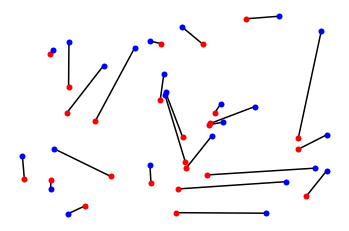

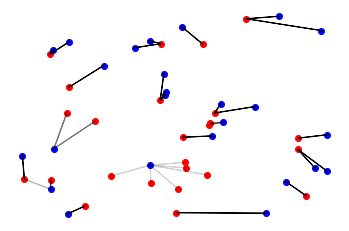

In [59]:
show_wasserstein2d(emd, weights0, coords0, weights1, coords1)
show_sinkhorn2d(x, y, P)

# corr between wasserstein and sinkhorn (2d)

In [8]:
w_list = []
s_list1 = []
s_list2 = []

iterations = 1000

for i in range(iterations):

    # data
    M = 100
    coords0, coords1 = np.random.rand(2, M, 2) 
    weights0, weights1 = np.ones([2,M])

    #wasserstein ---------------------------------------------
    emd = wasserstein.EMD(norm = True, n_iter_max = 10000)
    emd_val = emd(weights0, coords0, weights1, coords1)
    w_list.append(emd_val)


    #sinkhorn -------------------------------------------------
    x = torch.tensor(coords0, dtype=torch.float)
    y = torch.tensor(coords1, dtype=torch.float)

    sinkhorn = SinkhornDistance(eps=1, max_iter=10000, reduction='none')
    dist, P, C = sinkhorn(x, y)
    s_list1.append(dist.item())


    # GeomLoss
    loss = geomloss.SamplesLoss(loss='sinkhorn', p = 1, blur= 0.001)
    sinkhornLoss = loss(x,y)
    s_list2.append(sinkhornLoss)

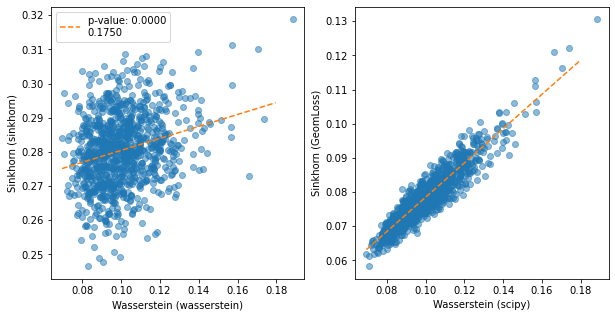

In [9]:
results1=stats.linregress(w_list, s_list1)
results2=stats.linregress(w_list, s_list2)

reg_x1 = np.arange(min(w_list), max(w_list), 0.01)
reg_y1 = results1.intercept + results1.slope*reg_x1

reg_x2 = np.arange(min(w_list), max(w_list), 0.01)
reg_y2 = results2.intercept + results2.slope*reg_x2

plt.figure(figsize=[10,5])

plt.subplot(1,2,1)
plt.plot(w_list, s_list1, 'o', alpha = 0.5)
plt.plot(reg_x1, reg_y1, '--', label = f'p-value: {results1.pvalue:.4f}\n{results1.slope:.4f}')
plt.xlabel('Wasserstein (wasserstein)')
plt.ylabel('Sinkhorn (sinkhorn)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(w_list, s_list2, 'o', alpha = 0.5)
plt.xlabel('Wasserstein (scipy)')
plt.ylabel('Sinkhorn (GeomLoss)')
plt.plot(reg_x2, reg_y2, '--', label = f'p-value: {results2.pvalue:.4f}\n{results2.slope:.4f}')
#plt.legend()


plt.show()

# 3D

### Wasserstein
- https://github.com/pkomiske/Wasserstein/
- https://github.com/pkomiske/Wasserstein/blob/master/demos/Wasserstein%20Demo.ipynb


### Sinkhorn
- https://dfdazac.github.io/sinkhorn.html
- https://github.com/dfdazac/wassdistance

In [10]:
def show_wasserstein3d(emdm, weights0, coords0, weights1, coords1):

    flows = emd.flows()

    # plot the events
    zf = 100
    plt.scatter(coords0[:,0], coords0[:,1], s=zf*weights0, lw=0, color='red')
    plt.scatter(coords1[:,0], coords1[:,1], s=zf*weights1, lw=0, color='blue')

    # plot flows
    cmap = plt.get_cmap('Greys')
    fmax = flows.max()
    for i in range(len(weights0)):
        for j in range(len(weights1)):
            f = flows[i,j]
            if f > 0.:
                plt.plot([coords0[i,0], coords1[j,0]], [coords0[i,1], coords1[j,1]],
                        lw=1.5, color=cmap(f/fmax), zorder=0)

    plt.axis('off')
    plt.show()


def show_sinkhorn3d(a, b, P):    
    norm_P = P/P.max()
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            plt.arrow(a[i, 0], a[i, 1], b[j, 0]-a[i, 0], b[j, 1]-a[i, 1],
                     alpha=norm_P[i,j].item())
    plt.scatter(a[:, 0], a[:, 1], s=a[:,2]*100, color='red')
    plt.scatter(b[:, 0], b[:, 1], s=b[:,2]*100, color='blue')
    plt.axis('off')

In [74]:
#data

# get some points in a euclidean space - but now also with magnitude/weights
M = 25 # go higer then and lap top can't allocate enough ram. No issue on computerome
coords0, coords1 = np.random.rand(2, M, 2) # would be spatial coordinates of dist0 and dist1
weights0, weights1 = np.random.rand(2, M) # would be the true/estimated values for each point.


#Wasserstein ----------------------------
emd = wasserstein.EMD(norm = True, n_iter_max = 10000)
emd_val = emd(weights0, coords0, weights1, coords1)
print('Wasserstein distance:', emd_val)


# Sinkhorn -------------------------------
a = np.column_stack([coords0, weights0])
b = np.column_stack([coords1, weights1])

x = torch.tensor(a, dtype=torch.float)
y = torch.tensor(b, dtype=torch.float)

sinkhorn = SinkhornDistance(eps=0.0001, max_iter=10000, reduction=None)
dist, P, C = sinkhorn(x, y)
print(f"Sinkhorn distance (sinkhorn): {dist.item()}")

# GeomLoss
#loss = geomloss.SamplesLoss(loss='sinkhorn', p = 1, blur= 0.001, verbose=False)
loss = geomloss.SamplesLoss(loss='sinkhorn', p = 2, blur= 0.05, scaling= 0.8, verbose=False)

# but you should not stack them - you should weight them.
# 6 args -> labels_i, weights_i, locations_i, labels_j, weights_j, locations_j

labels0t = torch.tensor(np.arange(0, coords0.shape[0], 1), dtype=torch.int)
labels1t = torch.tensor(np.arange(0, coords1.shape[0], 1), dtype=torch.int)

coords0t = torch.tensor(coords0, dtype=torch.float)
coords1t = torch.tensor(coords0, dtype=torch.float)

weights0t = torch.tensor(weights0, dtype=torch.float)
weights1t = torch.tensor(weights1, dtype=torch.float)


sinkhornLoss = loss(labels0t, weights0t, coords0t, labels1t, weights1t, coords1t)
print(f"Sinkhorn distance (GeomLoss): {sinkhornLoss}")

Wasserstein distance: 0.2004259265799375
Sinkhorn distance (sinkhorn): 0.07392498105764389
Sinkhorn distance (GeomLoss): 0.10594618320465088


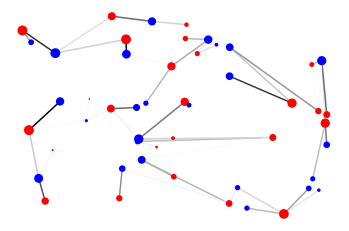

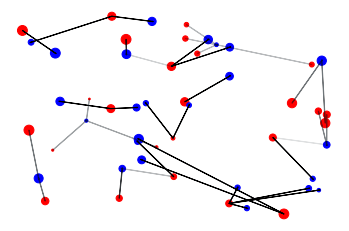

In [19]:
show_wasserstein3d(emd, weights0, coords0, weights1, coords1)
show_sinkhorn3d(a, b, P)

# corr between wasserstein and sinkhorn (3d)

In [82]:
w_list = []
s_list1 = []
s_list2 = []


iterations = 1000

for i in range(iterations):

    M = 100
    coords0, coords1 = np.random.rand(2, M, 2) 
    weights0, weights1 = np.random.rand(2, M) 


    #Wasserstein ----------------------------
    emd = wasserstein.EMD(n_iter_max = 10000)
    emd_val = emd(weights0, coords0, weights1, coords1)
    w_list.append(emd_val)

    # Sinkhorn -------------------------------
    a = np.column_stack([coords0, weights0])
    b = np.column_stack([coords1, weights1])

    x = torch.tensor(a, dtype=torch.float)
    y = torch.tensor(b, dtype=torch.float)

    sinkhorn = SinkhornDistance(eps=0.0001, max_iter=10000, reduction=None)
    dist, P, C = sinkhorn(x, y)
    s_list1.append(dist.item())

     # GeomLoss
    # loss = geomloss.SamplesLoss(loss='sinkhorn', p = 1, blur= 0.001)
    # sinkhornLoss = loss(x,y)

    # GeomLoss
    #loss = geomloss.SamplesLoss(loss='sinkhorn', p = 1, blur= 0.001, verbose=False)
    loss = geomloss.SamplesLoss(loss='sinkhorn', p = 1, blur= 0.05, verbose=False)

    # but you should not stack them - you should weight them.
    # 6 args -> labels_i, weights_i, locations_i, labels_j, weights_j, locations_j

    labels0t = torch.tensor(np.arange(0, coords0.shape[0], 1), dtype=torch.int)
    labels1t = torch.tensor(np.arange(0, coords1.shape[0], 1), dtype=torch.int)

    coords0t = torch.tensor(coords0, dtype=torch.float)
    coords1t = torch.tensor(coords0, dtype=torch.float)

    weights0t = torch.tensor(weights0, dtype=torch.float)
    weights1t = torch.tensor(weights1, dtype=torch.float)

    sinkhornLoss = loss(labels0t, weights0t, coords0t, labels1t, weights1t, coords1t)
    #print(f"Sinkhorn distance (GeomLoss): {sinkhornLoss}")

    s_list2.append(sinkhornLoss)

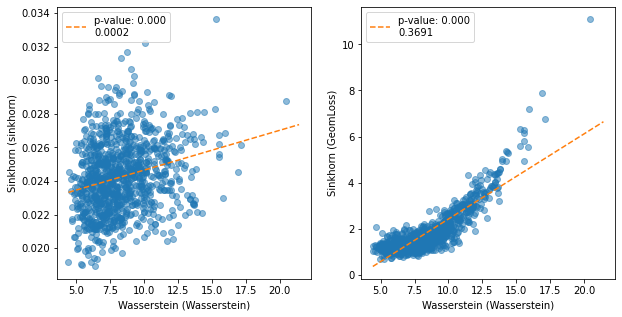

In [81]:
results1=stats.linregress(w_list, s_list1)
results2=stats.linregress(w_list, s_list2)

reg_x1 = np.arange(min(w_list), max(w_list)+1, 1)
reg_y1 = results1.intercept + results1.slope*reg_x1

reg_x2 = np.arange(min(w_list), max(w_list)+1, 1)
reg_y2 = results2.intercept + results2.slope*reg_x2

plt.figure(figsize=[10,5])

plt.subplot(1,2,1)
plt.plot(w_list, s_list1, 'o', alpha = 0.5)
plt.plot(reg_x1, reg_y1, '--', label = f'p-value: {results1.pvalue:.3f}\n{results1.slope:.4f}')
plt.xlabel('Wasserstein (Wasserstein)')
plt.ylabel('Sinkhorn (sinkhorn)')
plt.legend()


plt.subplot(1,2,2)
plt.plot(w_list, s_list2, 'o', alpha = 0.5)
plt.plot(reg_x2, reg_y2, '--', label = f'p-value: {results2.pvalue:.3f}\n{results2.slope:.4f}')
plt.xlabel('Wasserstein (Wasserstein)')
plt.ylabel('Sinkhorn (GeomLoss)')
plt.legend()



plt.show()

# sinkhorn (GeomLoss)
- https://www.kernel-operations.io/geomloss/index.html

In [105]:
start = time.time()

M = 4096 # =64x64 #10000 # 100000 = 57m 0.2 sec
coords0, coords1 = np.random.rand(2, M, 2)
weights0, weights1 = np.random.rand(2, M) 

loss = geomloss.SamplesLoss(loss='sinkhorn', p = 1, blur= 0.05, verbose=False)

labels0t = torch.tensor(np.arange(0, coords0.shape[0], 1), dtype=torch.int)
labels1t = torch.tensor(np.arange(0, coords1.shape[0], 1), dtype=torch.int)

coords0t = torch.tensor(coords0, dtype=torch.float)
coords1t = torch.tensor(coords0, dtype=torch.float)

weights0t = torch.tensor(weights0, dtype=torch.float)
weights1t = torch.tensor(weights1, dtype=torch.float)

sinkhornLoss = loss(labels0t, weights0t, coords0t, labels1t, weights1t, coords1t)

end = time.time()
run_time = (end - start)

print(f'runtime: {run_time:.1f} sec')
print(sinkhornLoss)


runtime: 3.9 sec
tensor(0.7750)


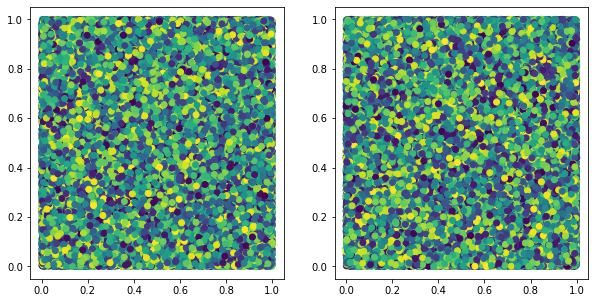

In [98]:
plt.figure(figsize= [10,5])

plt.subplot(1,2,1)
plt.scatter(coords0[:,0], coords0[:,1], c = weights0)
plt.subplot(1,2,2)
plt.scatter(coords1[:,0], coords1[:,1], c = weights1)
plt.show()

In [86]:
from scipy.spatial.distance import jensenshannon

In [90]:
p = np.column_stack([coords0, weights0])
q = np.column_stack([coords1, weights1])

jensenshannon(p,q)

array([0.32024634, 0.32025926, 0.32075521])

In [91]:
jensenshannon?

Signature: jensenshannon(p, q, base=None, *, axis=0, keepdims=False)
Docstring:
Compute the Jensen-Shannon distance (metric) between
two probability arrays. This is the square root
of the Jensen-Shannon divergence.

The Jensen-Shannon distance between two probability
vectors `p` and `q` is defined as,

.. math::

   \sqrt{\frac{D(p \parallel m) + D(q \parallel m)}{2}}

where :math:`m` is the pointwise mean of :math:`p` and :math:`q`
and :math:`D` is the Kullback-Leibler divergence.

This routine will normalize `p` and `q` if they don't sum to 1.0.

Parameters
----------
p : (N,) array_like
    left probability vector
q : (N,) array_like
    right probability vector
base : double, optional
    the base of the logarithm used to compute the output
    if not given, then the routine uses the default base of
    scipy.stats.entropy.
axis : int, optional
    Axis along which the Jensen-Shannon distances are computed. The default
    is 0.

    .. versionadded:: 1.7.0
keepdims : bool, optiona